<a href="https://colab.research.google.com/github/JpChii/ML-Projects/blob/main/09_skim_lit_40k_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ss_n

In [1]:
# Setting up extensions
%load_ext google.colab.data_table

In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [this notebook](https://github.com/JpChii/ML-Projects/blob/main/09_SkimLit_milestone_project.ipynb), Created and ran a series of experiments to find a model that's performaing well. The notebook uses these two papers below,

1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

In this notebook, we'll create and train our best model on the 200k dataset. If we can see any improvements.

# Creating and training our tribrid model on full 200k pubmed dataset

We're going to replicate the below architecture. Let's fix desired accuracy at 90%, if it's not performing up to the mark. we'll think of the next steps after that.

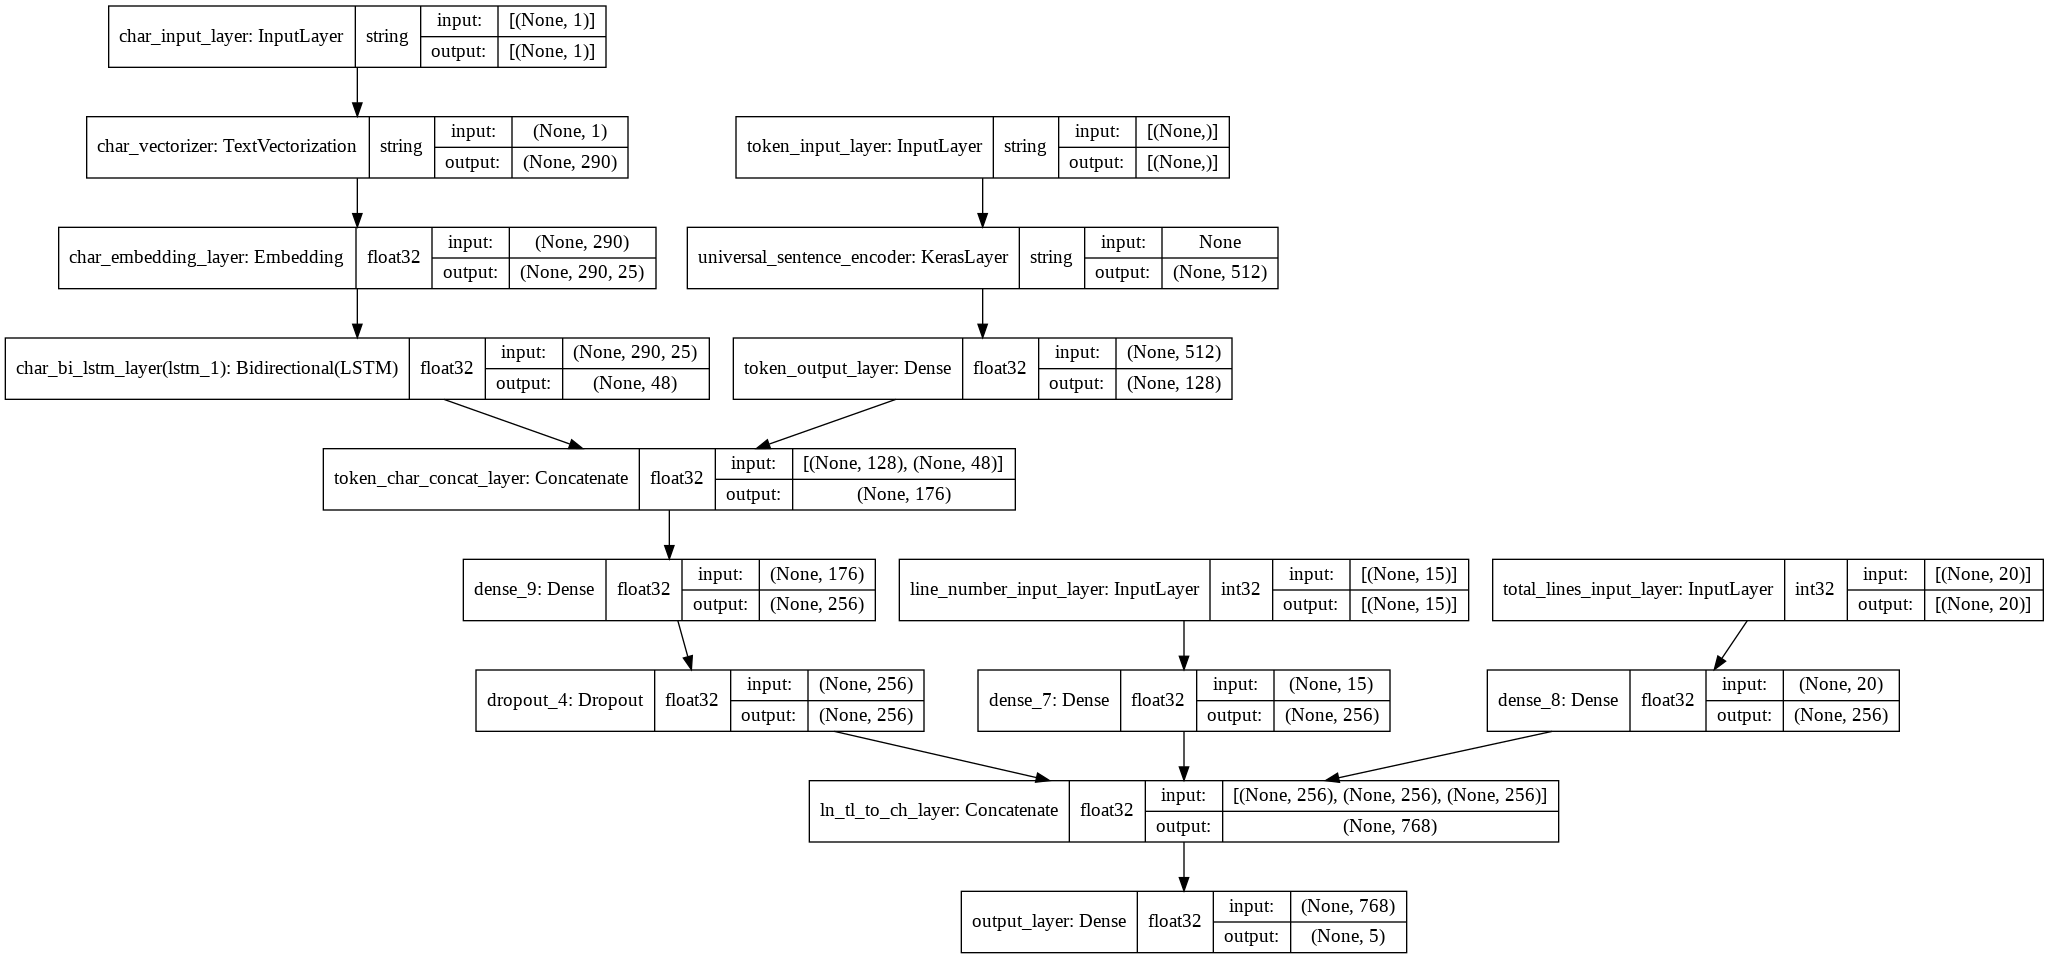

## Get the data

In the introduction section of the [dataset paper](https://arxiv.org/pdf/1710.06071.pdf) we can find the github link to download the data.

[Data github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.


### Get helper function

In [ ]:
!wget https://raw.githubusercontent.com/JpChii/ML-Tools/main/dl_helper.py

--2021-06-14 14:03:59--  https://raw.githubusercontent.com/JpChii/ML-Tools/main/dl_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17973 (18K) [text/plain]
Saving to: ‘dl_helper.py’

dl_helper.py        100%[===================>]  17.55K  --.-KB/s    in 0.001s  

2021-06-14 14:03:59 (27.6 MB/s) - ‘dl_helper.py’ saved [17973/17973]



In [ ]:
from dl_helper import walk_through_dir

In [ ]:
# Checkout the cloned repo directory
!ls "/content/pubmed-rct"

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Okay, so we have 20k and 200k dataset with two variants. In out parent notebook we've used `PubMed_20k_RCT_numbers_replaced_with_at_sign` and we'll use `PubMed_200k_RCT_numbers_replaced_with_at_sign` for comparison with previous models.

In [ ]:
# Chekout the 200RCT data directory
walk_through_dir("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign")

There are 0 directories and 3 images in '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign'.


In [ ]:
# Check the contents of the directory
!ls "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

dev.txt  test.txt  train.zip


We've three files for val(dev), train and test. Let's write some functions to preprocess these data.

## Preprocessing data

In this section we'll get the data from text file into pandas dataframe.

In [ ]:
# Creating a function to read the document and put into a list
def get_lines(filename):
  """
  Reads a file and returns the lines of text as a list
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a lsit of dictionaries of abstract line data
  """

  # Get all the lines into a list
  input_lines = get_lines(filename)
  # Create an emty abstract
  abstract_lines = ""
  # Create an empty list of abstracts
  abstract_samples = []

  # Loo[ through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # reset the abstract string in the line if it's an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # Split abstract into seperate lines

      # Iterate through each line in abstract lines and add line number and total lines
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # Split the data since they are seperate by tab
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower() # Get target text and lower it
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
# Unzip train.zip
from dl_helper import unzip_data
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

In [ ]:
train_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
!mv "/content/train.txt" "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# Let's read in the training data
train_dict = preprocess_text_with_line_numbers(train_dir + "train.txt")

In [ ]:
# Get val and test data as well 
val_dict = preprocess_text_with_line_numbers(train_dir + "dev.txt")
test_dict = preprocess_text_with_line_numbers(train_dir + "test.txt")

In [ ]:
# Check the length of the dict
len(train_dict), len(val_dict), len(test_dict)

(2211861, 28932, 29493)

We've got huge amount of data.

In [ ]:
import pandas as pd
# Convert the data to pandas dataframes
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)
test_df = pd.DataFrame(test_dict)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


After creating text vectorizer for character embedding and during `.adapt()`, method colab ran out of memory and kept crashing in the adapt cell. So we cannot traing the model with 200k dataset in free tier of colab even with GPU. So instead of full dataset. We'll go with 40% of the 200k dataset,

## Creating 40% PubMed dataset

In [ ]:
from sklearn.model_selection import train_test_split
train_40_per_df, train_60_per_df = train_test_split(train_df, test_size=0.6)
val_40_per_df, val_60_per_df = train_test_split(val_df, test_size=0.6)
test_40_per_df, val_40_per_df = train_test_split(test_df, test_size=0.6)

In [ ]:
len(train_df), len(train_40_per_df) + len(train_60_per_df), len(train_40_per_df), len(train_60_per_df)

(2211861, 2211861, 884744, 1327117)

## Turning data into numbers

Machine's hate text and love numbers, so right now our labels(`target`) and feature(`text`) are in text. We'll convert this to numbers.

In [ ]:
# Distribution of labels in training daa
label_dist = pd.DataFrame(train_40_per_df.target.value_counts().reset_index())
label_dist

,index,target
0,RESULTS,306784
1,METHODS,288918
2,CONCLUSIONS,135732
3,BACKGROUND,78515
4,OBJECTIVE,74795


### Visualizing label distribution

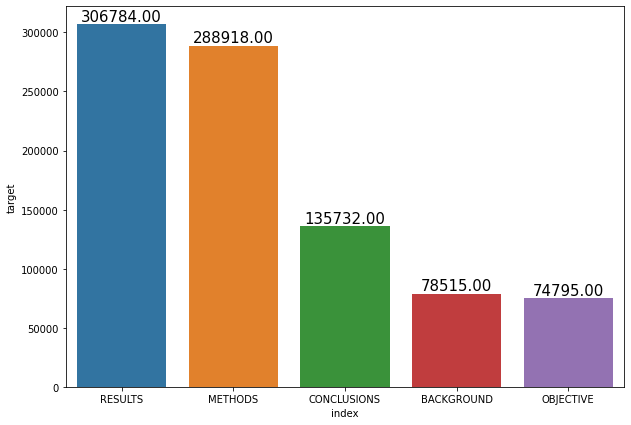

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
plot = sns.barplot(x="index", y="target", data=label_dist)

# Iterating over bars one by one
for bar in plot.patches:
  plot.annotate(format(bar.get_height(), '.2f'), # gets the value
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), # point in the plot fot text
                ha='center',
                va='center',
                size=15,
                xytext=(0,8),
                textcoords='offset points')
  
plt.show()

In [ ]:
306557 / 74529

4.1132579264447395

There's a difference in labels but not huge like 10x or 100x only 4x.

### Turning our target label into numbers

We're going to one_hot encode our labels

In [ ]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_40_per_df.target.to_numpy().reshape(-1,1)) # reshape(-1,1) we're asking numoy to determine the output shape of onehot encoding based on the categoricals
val_labels_one_hot = one_hot_encoder.transform(val_40_per_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_40_per_df.target.to_numpy().reshape(-1,1))

In [ ]:
train_labels_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

So, now the labels are converted to numbers. Next step is to convert text to numbers. The efficient way to convert learnable weights of our model is via embeddings.  Based on our best performing tribrid architecture. 

We need,

1. Token embeddings
      * For token embeddings we're going to use pretrained embeddings of `universal sentence encoder` from `TensorFlow Hub`. For this we just need a list of sentences.
2. Character embeddings
      * For character embedding, we're using custom embeddings layer. First we'll convert list of sentences to characters
      * Convert characters to integers using `TextVectorization`
      * Pass the vectors to `Custom embedding layer`
3. Positional embeddings
      * For positinal embeddings, we're gonna one-hot encode `line_number` and `total_lines` features.

Based on this the things we've to do next before proceesding with embeddings are,

1. Put sentences into a list
2. Convert sentencesw to characters


In [ ]:
# Convert sentences into a list
train_sentences = train_40_per_df.text.to_list()
val_sentences = val_40_per_df.text.to_list()
test_sentences = test_40_per_df.text.to_list()

In [ ]:
train_sentences[0]

'to evaluate efficacy and tolerability of unilateral ( rul ) and bilateral ( bl ) electroconvulsive therapy ( ect ) in the elderly with depression .'

In [ ]:
# Convert sentences to characters
def get_chars(text):
  return " ".join(list(text))

In [ ]:
get_chars(train_sentences[0])

't o   e v a l u a t e   e f f i c a c y   a n d   t o l e r a b i l i t y   o f   u n i l a t e r a l   (   r u l   )   a n d   b i l a t e r a l   (   b l   )   e l e c t r o c o n v u l s i v e   t h e r a p y   (   e c t   )   i n   t h e   e l d e r l y   w i t h   d e p r e s s i o n   .'

In [ ]:
# Use the function and create chars list
train_chars = [get_chars(sentence) for sentence in train_sentences]
val_chars = [get_chars(sentence) for sentence in val_sentences]
test_chars = [get_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   e v a l u a t e   e f f i c a c y   a n d   t o l e r a b i l i t y   o f   u n i l a t e r a l   (   r u l   )   a n d   b i l a t e r a l   (   b l   )   e l e c t r o c o n v u l s i v e   t h e r a p y   (   e c t   )   i n   t h e   e l d e r l y   w i t h   d e p r e s s i o n   .'

Now we've the list of sentences and characters

## Embeddings

Now we've all the stuff ready, let's create some embeddings

### Pretrained Token Embeddings

We'll use [Universal sentence encoder from tensorflow hub](https://tfhub.dev/google/universal-sentence-encoder/4)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
universal_sentence_encoder = hub.KerasLayer(handle="https://tfhub.dev/google/universal-sentence-encoder/4",
                                            trainable=False,
                                            input_shape=[],
                                            dtype=tf.string)

### Character Embeddings

For character embeddings, first we have to convert characters to numbers.

#### Character Vectorizer

In [ ]:
# Let's get all the different characters
# Since we're going to strip punctuation and numbers are already replaced by @, We'll include only the alphabets and special characters for out max tokens size
import string
char_tokens = string.ascii_lowercase
char_tokens

'abcdefghijklmnopqrstuvwxyz'

In [ ]:
len(char_tokens)

26

In [ ]:
# LEt's get the output sequence length for vectorizer
import numpy as np
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

147.8906960657546

In [ ]:
char_lens[0], len(train_sentences[0]), len(train_chars[0]) # Length of train_chars won;t give us the correct length since we're joining each charcter with a space before it

(147, 147, 293)

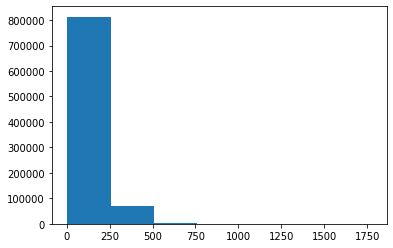

In [ ]:
# Check the distribution of character length across sentences
plt.hist(char_lens, bins=7);

In [ ]:
# Use percentile to find the length of 95%
output_char_seq_len =int(np.percentile(char_lens, 95))
output_char_seq_len

284

In [ ]:
# Create vectorizer
NUM_CHAR_TOKENS = len(char_tokens) + 2
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vectorizer_character = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  # num chars in alphabets + space + oov
                                         output_sequence_length=output_char_seq_len,
                                         name="char_vectorizer_layer")

> **Note:** adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

In [ ]:
%%time
# Adapt the text vectrorizer to train_chars
vectorizer_character.adapt(train_chars)

CPU times: user 3min 59s, sys: 5.2 s, total: 4min 4s
Wall time: 4min 3s


In [ ]:
len(train_chars)

884744

In [ ]:
# Check out the vocabulary
rct_80k_char_vocab = vectorizer_character.get_vocabulary()
print(f"Length of the vocabulay: {len(rct_80k_char_vocab)}")
print(f"Most frequent chars: {rct_80k_char_vocab[:5]}")
print(f"Least Frequent chars: {rct_80k_char_vocab[-5:]}")

Length of the vocabulay: 28
Most frequent chars: ['', '[UNK]', 'e', 't', 'a']
Least Frequent chars: ['k', 'x', 'z', 'q', 'j']


Now the vectorizer is done, let's create character embedding layer

#### Custom character Embedding

In [ ]:
import tensorflow as tf
embedding_character = tf.keras.layers.Embedding(input_dim=len(rct_80k_char_vocab),
                                                output_dim=25, # IS the character embedding dimension used in the paper
                                                mask_zero=True)

Now token embedding and charcter embedding are done. Now let's next move onto positonal embeddings.

### Positional embedding

As Positional embedding, we alredy have the features `line_number` and `total_lines` as numerical. Let;s just one-hot encode them and move on to modelling.

1. One-hot encode line_number
2. One-hot enocde toal_line

#### One-Hot encode line_number

In [ ]:
# Check the value counts of line number
train_40_per_df.line_number.value_counts()

3     76527
1     76419
0     76322
4     76208
5     76020
2     75821
6     74252
7     70964
8     65441
9     57202
10    46980
11    36188
12    26126
13    17805
14    11632
15     7614
16     4708
17     3011
18     1889
19     1182
20      757
21      538
22      308
23      222
24      145
25      120
26       84
28       56
27       54
29       35
30       26
31       16
32       15
33       12
35        9
34        6
36        6
41        4
45        3
38        3
37        2
39        2
44        2
48        1
47        1
46        1
49        1
43        1
42        1
40        1
50        1
Name: line_number, dtype: int64

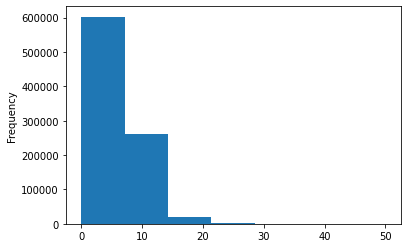

In [ ]:
# Check the distribution
train_40_per_df.line_number.plot(kind="hist", bins=7);

In [ ]:
# Check the 98 percentile to be used as the depth of the one-hot encoding
line_number_one_hot_depth = int(np.percentile(train_40_per_df.line_number, 98))
line_number_one_hot_depth

15

In [ ]:
import tensorflow as tf
# One-hot encode
train_line_numbers_one_hot = tf.one_hot(train_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
val_line_numbers_one_hot = tf.one_hot(val_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
test_line_numbers_one_hot = tf.one_hot(test_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
train_line_numbers_one_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

Now line number is completed, let's do the same for total lines.

#### One-Hot encode total_lines

In [ ]:
# Check the value counts of total lines
train_40_per_df.total_lines.value_counts()

10    121908
11    121612
12    106848
9     103629
13     85005
8      73806
14     62264
15     44683
7      43816
16     30100
6      21116
17     19223
18     12531
19      8770
5       8597
20      5480
21      4027
4       2528
22      2276
23      1615
24      1076
25       739
26       575
3        481
27       449
28       355
29       311
33       187
31       172
30       115
32       115
35        77
34        58
37        44
36        41
49        21
50        20
45        19
46        19
40        15
43        11
2         10
Name: total_lines, dtype: int64

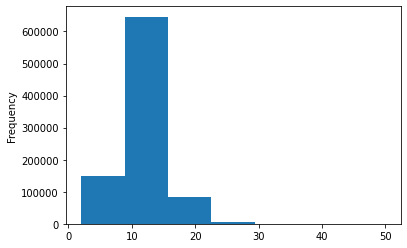

In [ ]:
# Checkout the distribution
train_40_per_df.total_lines.plot(kind="hist", bins=7)

In [ ]:
# Get the 98th percentile for one hot encode depth
total_lines_one_hot_encode_depth = int(np.percentile(train_40_per_df.total_lines, 98))
total_lines_one_hot_encode_depth

20

In [ ]:
# Let's encode them
train_total_lines_one_hot = tf.one_hot(train_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
val_total_lines_one_hot = tf.one_hot(val_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
test_total_lines_one_hot = tf.one_hot(test_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.]], dtype=float32)>

Now we've all the embeddings ready. Nex step is to prepate the data to be loaded efficiently into GPU's memory and fast training. Since we're dealing with huge data, we'll write some callbacks as well.

Next steps will be,

1. Setup Mixed precison - model layers will use lower precision whenever possible without affecting the numericaL stability
2. Build the model from our tribrid architecture
3. Create fast loading `tf.data.Dataset`
4. Train the model
5. Evaluate the model

## Modelling

### Setting up mixed precision

In [ ]:
import tensorflow as tf
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


### Building the model

In [ ]:
# Imports
from tensorflow.keras import layers

In [ ]:
# 1. Token level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input_layer") # Input shape is list because unviersal sentence encoder accepts a list of sentences and return 512 dimension embedding
embeds_token = universal_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="token_output_layer")(embeds_token)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs,
                             name="token_level_model")

In [ ]:
# 2. Character level model
char_input = layers.Input(shape=(1, ), dtype=tf.string, name="char_input_layer")
vectors_char = vectorizer_character(char_input)
embeds_char = embedding_character(vectors_char)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(embeds_char)
char_model = tf.keras.Model(inputs=char_input,
                            outputs=char_bi_lstm,
                            name="char_level_model")

In [ ]:
# 3. Line number mode
line_number_input = layers.Input(shape=(line_number_one_hot_depth,), dtype=tf.float16, name="line_no_input_layer")
line_number_output = layers.Dense(256, activation="relu", name="line_no_output_layer")(line_number_input)
line_number_mode = tf.keras.Model(inputs=line_number_input,
                                  outputs=line_number_output,
                                  name="line_no_model")

In [ ]:
# 4. Total lines model
total_lines_input = layers.Input(shape=(total_lines_one_hot_encode_depth,), dtype=tf.float16, name="total_lines_input_layer")
total_lines_output = layers.Dense(256, activation="relu", name="total_lines_output_layer")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   outputs=total_lines_output,
                                   name="total_lines_model")

In [ ]:
# 5. Concatenate token level and character level outputs
z = layers.Concatenate(name="token_char_concat_layer")([token_model.output, char_model.output])

In [ ]:
# 6. Add a dense layer and droput as mentioned in the paper after concatenation
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.5)(z) # dropout layer for regulariation(to prevent overfitting, forcing the model to learn different paths to desired output)

In [ ]:
# 7. Concatenate lineno and totalline output with z
ln_tl_to_ch_concat = layers.Concatenate(name="token_char_ln_tl_concat_layer")([line_number_mode.output, total_lines_model.output, z])

In [ ]:
# 8. We'll have the activation layers seperate for numerical stability
x = layers.Dense(5, name="final_dense_layer")(ln_tl_to_ch_concat)
output_layer = layers.Activation(activation="softmax", name="output_layer", dtype=tf.float32)(x)

In [ ]:
# 9. Building the model
model = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_mode.input, total_lines_model.input],
                       outputs=output_layer)

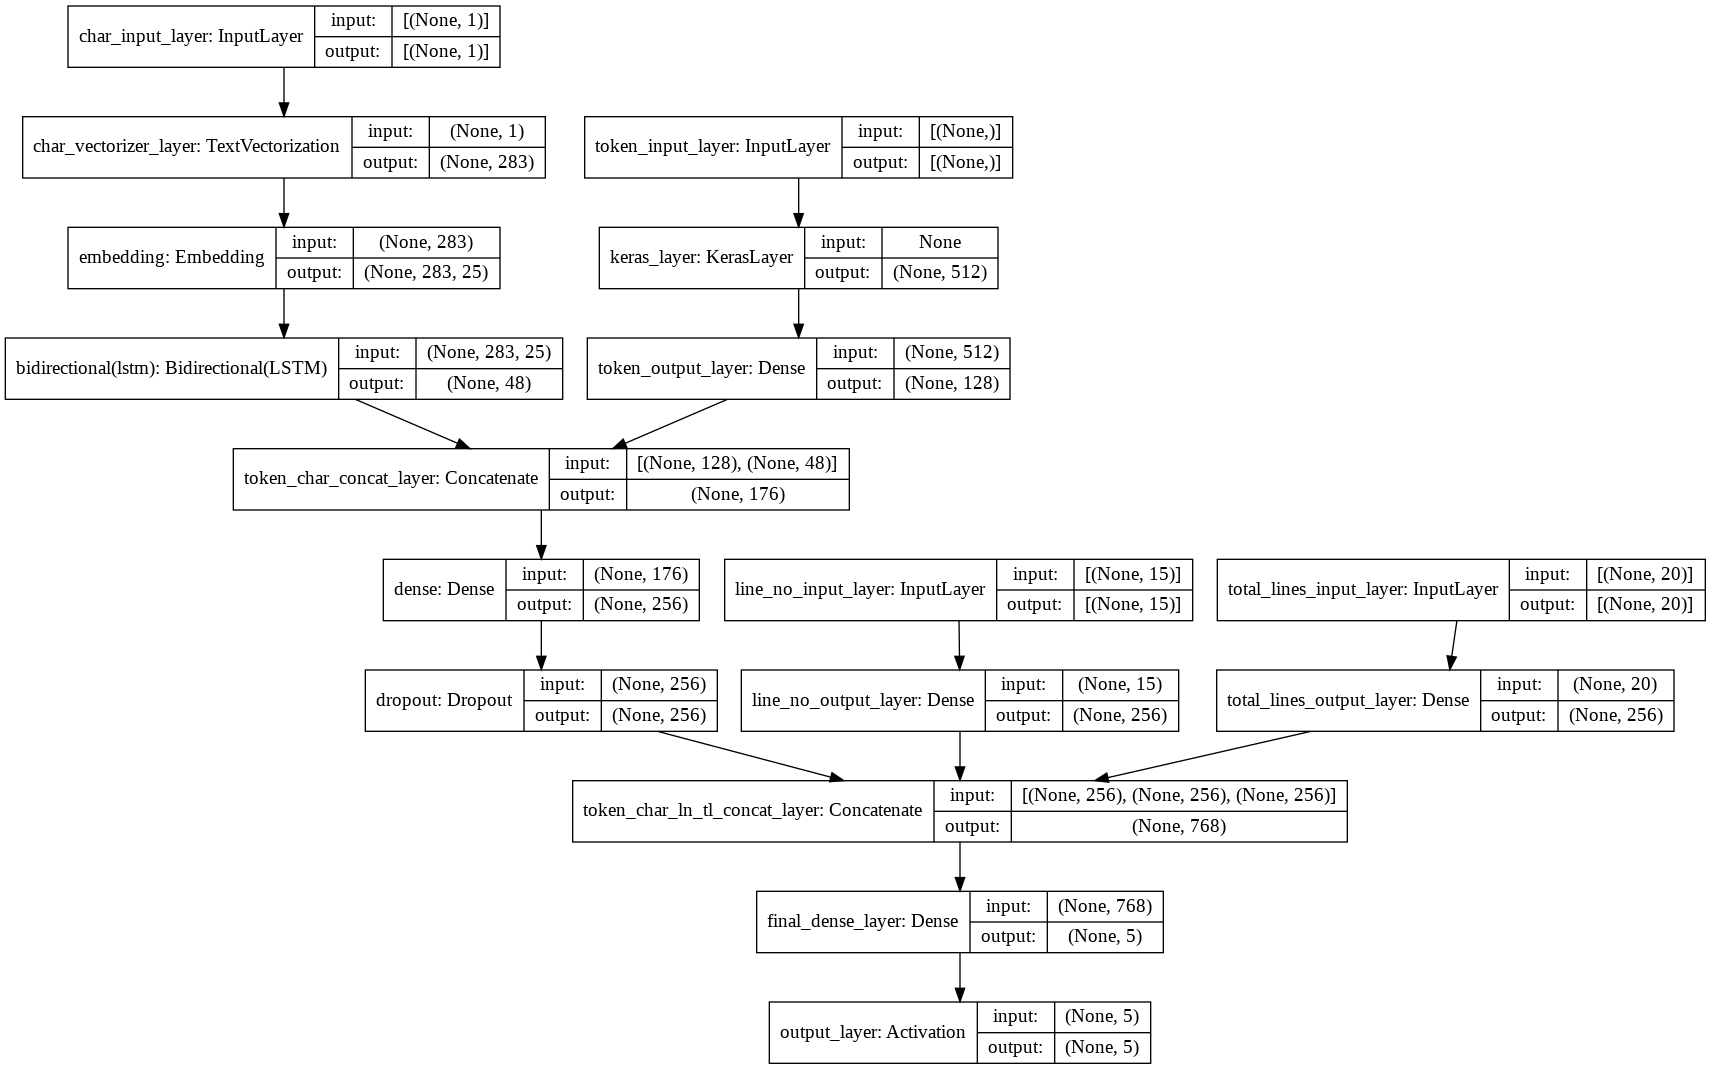

In [ ]:
# Checkout the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Look at the beautiful tribrid mode architecture. Now all left is to prepare the dataset and callbacks before training.

## Creating `tf.data` Dataset

The dataset should have the same order the inputs passed to the model.

First we'll convert our data to tensors. We converted our data to list and array for this purpose

In [ ]:
# First data
train_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
val_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
test_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_numbers_one_hot, test_total_lines_one_hot))

Created a tuple of `(sentencs, chars, line_number, total_lines)` for train, test, val.

Next is the label, label is common for all these four data. Let's create that next

In [ ]:
# Labels
train_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
val_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
test_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

In [ ]:
# Now let's zip data and label together into a single tuple
train_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(train_to_ch_ln_tl_data, train_to_ch_ln_tl_labels))
val_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(val_to_ch_ln_tl_data, val_to_ch_ln_tl_labels))
test_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(test_to_ch_ln_tl_data, test_to_ch_ln_tl_labels))

train_to_ch_ln_tl_dataset

<ZipDataset shapes: (((), (), (15,), (20,)), (5,)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

In [ ]:
model.input_shape

NameError: ignored

In [ ]:
# Converint ZipDataset to Prefetch dataset
train_to_ch_ln_tl_dataset = train_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_to_ch_ln_tl_dataset = val_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_to_ch_ln_tl_dataset = test_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_to_ch_ln_tl_dataset

<PrefetchDataset shapes: (((None,), (None,), (None, 15), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

Now Dataset is also created, only creation of callbacks is left.

In [ ]:
# Data and labels seperate
train_to_ch_ln_tl_data = train_to_ch_ln_tl_data.batch(32).prefetch(tf.data.AUTOTUNE)
train_to_ch_ln_tl_labels

<PrefetchDataset shapes: (None, 5), types: tf.float64>

In [ ]:
val_to_ch_ln_tl_data = val_to_ch_ln_tl_data.batch(32).prefetch(tf.data.AUTOTUNE)
val_to_ch_ln_tl_labels

<PrefetchDataset shapes: (None, 5), types: tf.float64>

## Creation of callbacks

In [ ]:
# Tensorboard callback for logging
from dl_helper import create_tensorboard_callback

In [ ]:
# Checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/",
                                                         monitor="val_accuracy",
                                                        verbose=1,
                                                         save_best_only=True,
                                                         save_weights_only=True)

In [ ]:
# Early stopping callback
ealy_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=3,
                                                          verbose=1)

In [ ]:
# Reductin on plateau callback
rl_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                   factor=0.2,
                                                   patience=3,
                                                   verbose=1,
                                                   min_lr=1e-7)

Now all the stuff are done, all left is to compile and train the model.

In [ ]:
from dl_helper import save_model

In [ ]:
# Compile the mode
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [ ]:
# # Fit the model
# history = model.fit(train_to_ch_ln_tl_dataset,
#                     epochs=5,
#                     validation_data=val_to_ch_ln_tl_dataset,
#                     validation_steps=int(0.1 * len(val_to_ch_ln_tl_dataset))
#                     callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/ML_logs/09_skimlit",
#                                                            experiment_name="tribrid_model_40k_dataset"),
#                                checkpoint_callback,
#                                ealy_stopping_callback,
#                                rl_callback])

Saving TensorBoard log files to: /content/drive/MyDrive/ML_logs/09_skimlit/tribrid_model_40k_dataset/20210610-151546
Epoch 1/10
27649/27649 [==============================] - 1304s 47ms/step - loss: 0.9096 - accuracy: 0.8512 - val_loss: 0.8864 - val_accuracy: 0.8649

Epoch 00001: val_accuracy improved from -inf to 0.86488, saving model to /content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/
Epoch 2/10
27649/27649 [==============================] - 1287s 47ms/step - loss: 0.8889 - accuracy: 0.8654 - val_loss: 0.8786 - val_accuracy: 0.8723

Epoch 00002: val_accuracy improved from 0.86488 to 0.87234, saving model to /content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/
Epoch 3/10
27649/27649 [==============================] - 1297s 47ms/step - loss: 0.8809 - accuracy: 0.8709 - val_loss: 0.8763 - val_accuracy: 0.8723

Epoch 00003: val_accuracy did not improve from 0.87234
Epoch 4/10
27649/27649 [==============================] - 1290s 47ms/step - loss: 0.8759 - accuracy: 0.8743 - va

So training on 40 percent data, we got only 2 percent increase in accuracy with huge increase in training time compared with the previous notebook using 10 percent data. This excercise might've been futile considering we've increased the data 3x. But let's save the model for the time being as it's performing the best for future use. And we also need to figure out if there's a way to configure early stopping callback to ignore decimal changes as improvements.

The training of the big model stopped at 9th epoch due to GPU runtime exceeded in colab. But the weights are stored in `/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per`. We'll load the weights and compare the metrics. If they're not as expected, we've no other way then to retrain the model.

In [ ]:
# Load weights
model.load_weights("/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/")

In [ ]:
# Make some predictions
pred_probs = model.predict(val_to_ch_ln_tl_dataset)
preds = tf.argmax(pred_probs, axis=1)
preds[:5]

NameError: ignored

In [ ]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_40_per_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_40_per_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [ ]:
from dl_helper import calculate_results
# Calculate metrics
resutls_40_per = calculate_results(y_true=val_labels_encoded,
                                   y_pred=preds)

In [ ]:
resutls_40_per

{'accuracy': 0.8759041591320073,
 'f1': 0.8746010434593687,
 'precision': 0.8747085760351476,
 'recall': 0.8759041591320073}

Okay the accuracy is close to when the training gor interrupted. Let's load in the previous results and compare this.

In [ ]:
RESULTS_DF_PATH = "/content/drive/MyDrive/ML_data/skimlit_results.csv"
results_df = pd.read_csv(RESULTS_DF_PATH)
results_df

,Unnamed: 0,baseline,model1_conv1d,model2_use,model3_conv_with_char_embed,model4_tok_plus_char,model5_tribrid_embed
0,accuracy,0.721832,0.755627,0.714815,0.612008,0.731696,0.838078
1,f1,0.698925,0.788440,0.715481,0.613615,0.731157,0.837084
2,precision,0.718647,0.755627,0.714815,0.612008,0.731696,0.838078
3,recall,0.721832,0.764967,0.711805,0.592860,0.728691,0.836908


In [ ]:
results_df = results_df.set_index('Unnamed: 0')
results_df

,baseline,model1_conv1d,model2_use,model3_conv_with_char_embed,model4_tok_plus_char,model5_tribrid_embed
Unnamed: 0,,,,,,
accuracy,0.721832,0.755627,0.714815,0.612008,0.731696,0.838078
f1,0.698925,0.788440,0.715481,0.613615,0.731157,0.837084
precision,0.718647,0.755627,0.714815,0.612008,0.731696,0.838078
recall,0.721832,0.764967,0.711805,0.592860,0.728691,0.836908


In [ ]:
# Setting results 40 percent manually to avoid retraining
results_40_per_man_entry = {'accuracy': 0.8759041591320073,
                            'f1': 0.8746010434593687,
                            'precision': 0.8747085760351476,
                            'recall': 0.8759041591320073}

In [ ]:
results_df["model6_tribrid_40_per"] = results_40_per_man_entry.values()
results_df.T

Unnamed: 0,accuracy,f1,precision,recall
baseline,0.721832,0.698925,0.718647,0.721832
model1_conv1d,0.755627,0.788440,0.755627,0.764967
model2_use,0.714815,0.715481,0.714815,0.711805
model3_conv_with_char_embed,0.612008,0.613615,0.612008,0.592860
model4_tok_plus_char,0.731696,0.731157,0.731696,0.728691
model5_tribrid_embed,0.838078,0.837084,0.838078,0.836908
model6_tribrid_40_per,0.875904,0.874709,0.875904,0.874601


Okay looking at the results dataframe, the training might not've been a complete failure. We've got a 5% increase in accuracy wooooh...!

### Save the model

In [ ]:
# Let's save this model
from dl_helper import save_model
SKIM_LIT_MODEL_SAVE_DIR = "/content/drive/MyDrive/ML_models/09_skimlit"
save_model(model=model,
           model_name="tribrid_40_per_87_acc",
           target_dir=SKIM_LIT_MODEL_SAVE_DIR)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_87_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_87_acc/assets


### Confusion matrix

In [ ]:
# Getting class names
class_names= label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
from dl_helper import make_confusion_matrix
make_confusion_matrix(y_true=val_labels_encoded,
                      y_pred=preds,
                      classes=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
                      text_size=10)

NameError: ignored

Looking at the conf matrix, it's getting confused with objective vs background

In [ ]:
pred_probs

In [ ]:
predictions_df = pd.DataFrame({"Text": val_sentences,
                               "truth": class_names[val_labels_encoded],
                               "preds": class_names[preds],
                               "prob": np.max(pred_probs)})
predictions_df["Is pred correct"] = predictions_df['truth'] != predictions_df['preds']
predictions_df[:10]

,Text,truth,preds,prob,Is pred correct
0,patients stated that using vr made the treatme...,CONCLUSIONS,RESULTS,0.979387,True
1,"measurements and main outcome : relapse , defi...",METHODS,METHODS,0.979387,False
2,correction of subclinical coagulation disorder...,CONCLUSIONS,CONCLUSIONS,0.979387,False
3,"in addition , the stability of individual impl...",METHODS,METHODS,0.979387,False
4,plasma vitamin a concentrations remained uncha...,RESULTS,RESULTS,0.979387,False
5,a total of @ eligible patients with pt@-@a and...,METHODS,METHODS,0.979387,False
6,forty-five patients of t@dm with hypertension ...,METHODS,METHODS,0.979387,False
7,the safety profile of diapep@ was similar betw...,RESULTS,RESULTS,0.979387,False
8,the majority ( @ % ) had no or mild melasma ( ...,RESULTS,RESULTS,0.979387,False
9,a single experienced operator completed @ sono...,METHODS,METHODS,0.979387,False


In [ ]:
# Getting only the wrong
wrong_df = predictions_df[predictions_df['Is pred correct'] == True]
top_100_wrong = wrong_df.sort_values(by="prob", ascending=False)[:100]
top_100_wrong

,Text,truth,preds,prob,Is pred correct
0,patients stated that using vr made the treatme...,CONCLUSIONS,RESULTS,0.979387,True
12093,the purpose of this pilot study was to develop...,METHODS,OBJECTIVE,0.979387,True
12041,we investigated the efficacy and safety of tic...,BACKGROUND,OBJECTIVE,0.979387,True
12054,we assessed whether the use of a high dose of ...,METHODS,OBJECTIVE,0.979387,True
12057,we hypothesized that a @:@ c : v ratio will de...,OBJECTIVE,BACKGROUND,0.979387,True
...,...,...,...,...,...
11298,during traditional abdominal and vaginal surge...,METHODS,RESULTS,0.979387,True
11294,hypoglycemia is a critical obstacle to the car...,OBJECTIVE,BACKGROUND,0.979387,True
11293,"between april @ and august @ , @ ( @ % ) of @ ...",RESULTS,METHODS,0.979387,True
11285,gabapentin may reduce these symptoms and help ...,OBJECTIVE,BACKGROUND,0.979387,True


Okay when i started this notebook, 90% accuracy was the target. Wasn't able to achieve this by increasing the data. Now let's try some model changes with addition to this data increase.

1. Use a different [TF hub BERT pretrained pub med expert](https://tfhub.dev/google/experts/bert/pubmed/2) in our token level model.
2. Combine line_number and total_lines feature

## Changing the pretrained embeddings

This pretrained embedding has a preprocessing step, let's import that too.

In [ ]:
!pip3 install --quiet tensorflow-text
import tensorflow_hub as hub
import tensorflow as tf

import tensorflow_text as text  # Imports TF ops for preprocessing.
# Preprocessing
preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                            input_shape=[],
                            dtype=tf.string,
                            name="bert_preprocess_layer")
# Bert layer
bert_layer = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2",
                            trainable=False,
                            input_shape=[],
                            dtype=tf.string,
                            name="bert_layer")

     |████████████████████████████████| 4.3MB 8.4MB/s 


In [ ]:
pre = preprocess([train_sentences[0]])
embeds = bert_layer(pre)
pooled_output = embeds['pooled_output']
seq_output = embeds['sequence_output']
print(pooled_output.shape)
print(seq_output.shape)

(1, 768)
(1, 128, 768)


In [ ]:
from tensorflow.keras import layers
# Building the model
# 1. Token level model
token_input_bert = layers.Input(shape=[], dtype=tf.string, name="token_input_layer")
preprocess_bert = preprocess(token_input_bert)
embeds_bert = bert_layer(preprocess_bert)
pooled_bert_output = embeds_bert['pooled_output']
token_output_bert = layers.Dense(128, activation="relu", name="token_output_layer")(pooled_bert_output)
token_model_bert = tf.keras.Model(inputs=token_input_bert,
                                  outputs=token_output_bert)

# 2. Character level model
char_input_bert = layers.Input(shape=(1, ), dtype=tf.string, name="char_input_layer")
vectors_char_bert = vectorizer_character(char_input_bert)
embeds_char_bert = embedding_character(vectors_char_bert)
char_bi_lstm_bert = layers.Bidirectional(layers.LSTM(24))(embeds_char_bert)
char_model_bert = tf.keras.Model(inputs=char_input_bert,
                                 outputs=char_bi_lstm_bert)

# 3. Line number model
line_number_input_bert = layers.Input(shape=(line_number_one_hot_depth, ), dtype=tf.float16, name="line_number_input_layer")
line_number_output_bert = layers.Dense(256, activation="relu", name="line_number_output_layer")(line_number_input_bert)
line_number_model_bert = tf.keras.Model(inputs=line_number_input_bert,
                                        outputs=line_number_output_bert)

# 4. Total lines model
total_lines_input_bert = layers.Input(shape=(total_lines_one_hot_encode_depth, ), dtype=tf.float16, name="total_lines_input_layer")
total_lines_output_bert = layers.Dense(256, activation="relu", name="total_lines_output_layer")(total_lines_input_bert)
total_line_model_bert = tf.keras.Model(inputs=total_lines_input_bert,
                                       outputs=total_lines_output_bert)

In [ ]:
# 5. Concatenate token, char outputs
z = layers.Concatenate(name="token_char_concatenate")([token_model_bert.output, char_model_bert.output])
z = layers.Dense(128, activation="relu")(z)
z = layers.Dropout(0.5, name="dropoiut_layer")(z)

# 6. Concatenate line no, total lines outputs
z = layers.Concatenate(name="all_outputs_concatenate")([line_number_model_bert.output, total_line_model_bert.output, z])

# 7. Dense layer
z = layers.Dense(5)(z)

# 8. Activation layer
output_layer = layers.Activation("softmax", name="output_layer", dtype=tf.float32)(z)

In [ ]:
# 9. Create model
model_bert = tf.keras.Model(inputs=[token_model_bert.input, char_model_bert.input, line_number_model_bert.input, total_line_model_bert.input],
                           outputs=output_layer)

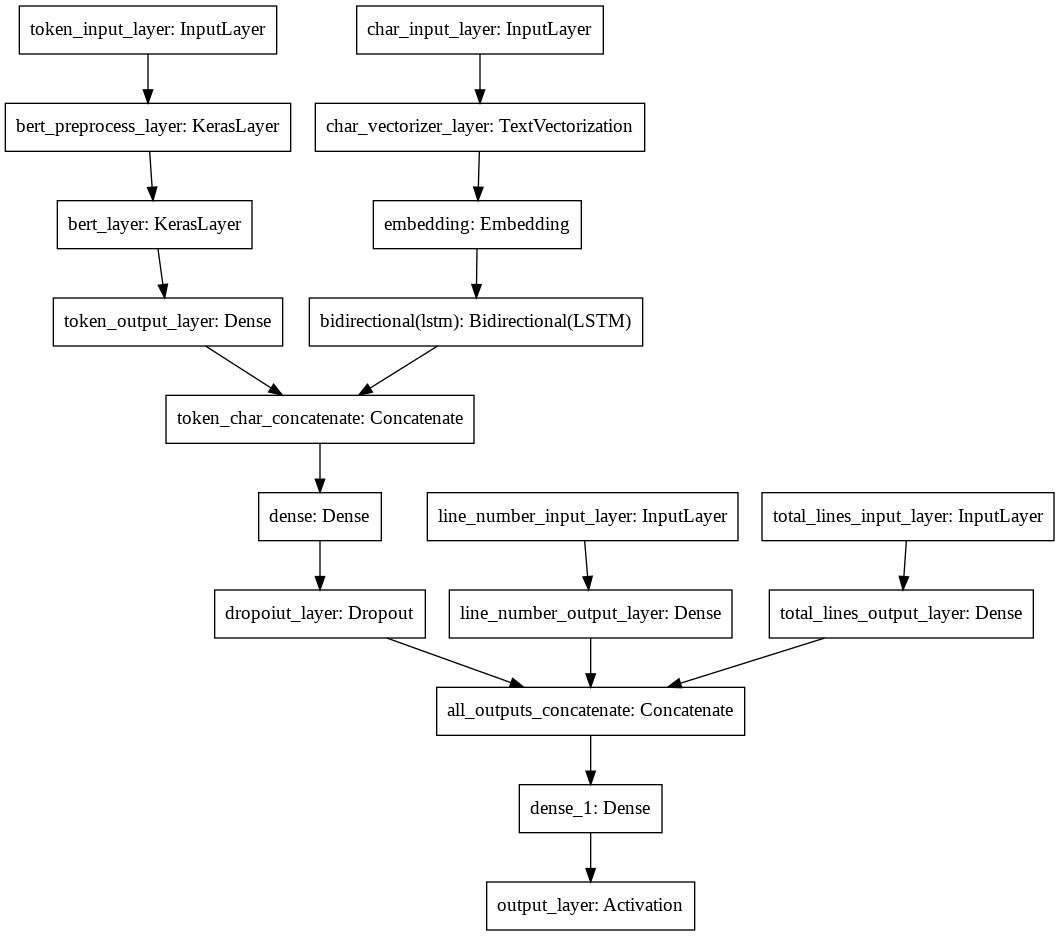

In [ ]:
from tensorflow.keras.utils import plot_model
# Checkout the model architecture
plot_model(model_bert)

In [ ]:
# Compile the model
model_bert.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [ ]:
# Fit the model
history_bert = model_bert.fit([train_sentences, train_chars, train_line_numbers_one_hot, train_toal_n],
                              train_to_ch_ln_tl_labels,
                              epochs=5,
                              steps_per_epoch=int(0.2 * len(train_to_ch_ln_tl_dataset)),
                              validation_data=(val_to_ch_ln_tl_data, val_to_ch_ln_tl_labels),
                              validation_steps=int(0.1 * len(val_to_ch_ln_tl_data)),
                              callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/ML_logs/09_skimlit",
                                                                     experiment_name="40_per_bert"),
                                         ealy_stopping_callback,
                                         rl_callback,
                                         checkpoint_callback])

Saving TensorBoard log files to: /content/drive/MyDrive/ML_logs/09_skimlit/40_per_bert/20210614-141710


ValueError: ignored

In [ ]:
# Evalaute on the full data
model_bert.evaluate(val_to_ch_ln_tl_dataset)

553/553 [==============================] - 188s 339ms/step - loss: 0.8340 - accuracy: 0.8938


[0.8340327143669128, 0.8938177824020386]

In [ ]:
# Make some predictions
pred_probs_bert = model_bert.predict(val_to_ch_ln_tl_dataset)
# Make preds
preds_bert = tf.argmax(pred_probs_bert, axis=1)
preds_bert

<tf.Tensor: shape=(17696,), dtype=int64, numpy=array([4, 2, 3, ..., 2, 4, 4])>

In [ ]:
from dl_helper import calculate_results
# Checkout the reusults
results_model_bert = calculate_results(y_true=val_labels_encoded,
                                       y_pred=preds_bert)
results_model_bert

{'accuracy': 0.8938178119349005,
 'f1': 0.8922672449239366,
 'precision': 0.8980810894569682,
 'recall': 0.8938178119349005}

In [ ]:
results_df["model7_tribrid_bert_40_per"] = results_model_bert.values()
results_df.T

Unnamed: 0,accuracy,f1,precision,recall
baseline,0.721832,0.698925,0.718647,0.721832
model1_conv1d,0.755627,0.788440,0.755627,0.764967
model2_use,0.714815,0.715481,0.714815,0.711805
model3_conv_with_char_embed,0.612008,0.613615,0.612008,0.592860
model4_tok_plus_char,0.731696,0.731157,0.731696,0.728691
model5_tribrid_embed,0.838078,0.837084,0.838078,0.836908
model6_tribrid_40_per,0.875904,0.874601,0.874709,0.875904
model7_tribrid_bert_40_per,0.893818,0.898081,0.893818,0.892267


The model has reached 89% accuracy which is a improvement but, we're yet to breach our 90% target.

As our last try let's make the layer trainable and retrain the model

In [ ]:
model_bert.save("/content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_89_acc")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_89_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_89_acc/assets


In [ ]:
# Make confusion matrix
from dl_helper import make_confusion_matrix

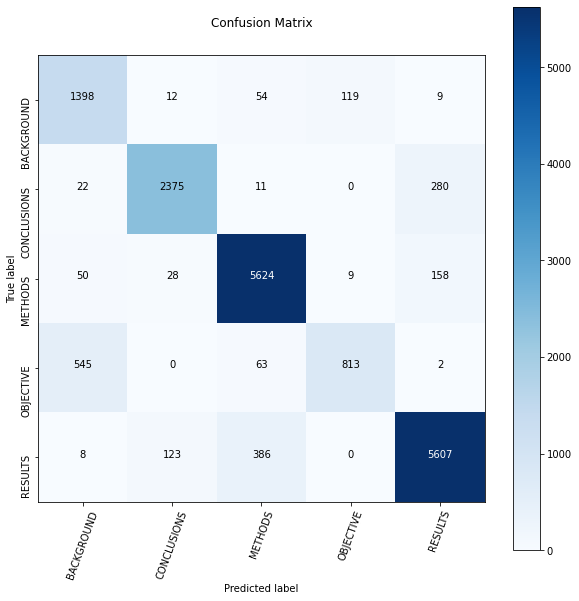

In [ ]:
make_confusion_matrix(y_true=val_labels_encoded,
                      y_pred=preds_bert,
                      classes=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
                      text_size=10)

In [ ]:
# Let's make the bert layers teainable
bert_layer.trainable = False

In [ ]:
# Recompile the model
model_bert.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

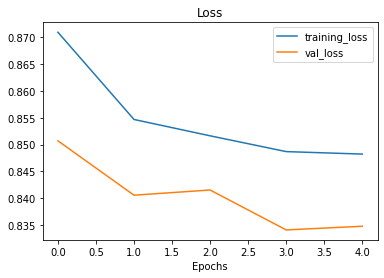

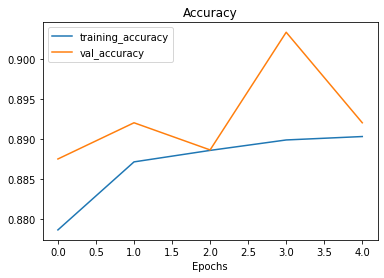

In [ ]:
# Checkout the loss curve
from dl_helper import plot_loss_curves, compare_historys
plot_loss_curves(history_bert)

In [ ]:
# Checkpoint callback
checkpoint_callback_bert_fine_tune = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per_bert_fine_tune/",
                                                         monitor="val_accuracy",
                                                        verbose=1,
                                                         save_best_only=True,
                                                         save_weights_only=True)

In [ ]:
# Fine tune fit
history_bert_5_more_epochs = model_bert.fit(train_to_ch_ln_tl_dataset,
                                        epochs=5,
                                        initial_epoch=history_bert.epoch[-1],
                                        steps_per_epoch=int(0.2 * len(train_to_ch_ln_tl_dataset)),
                                        validation_data=val_to_ch_ln_tl_dataset,
                                        validation_steps=(0.1 * len(val_to_ch_ln_tl_dataset)),
                                        callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/ML_logs/09_skimlit",
                                                                     experiment_name="40_per_bert_more_epochs"),
                                         ealy_stopping_callback,
                                         rl_callback,
                                         checkpoint_callback_bert_fine_tune])

Saving TensorBoard log files to: /content/drive/MyDrive/ML_logs/09_skimlit/40_per_bert_more_epochs/20210612-094015
Epoch 5/5
 783/5529 [===>..........................] - ETA: 28:02 - loss: 1.1302 - accuracy: 0.6820

We've created some preprocessing functions in [this notebook](https://colab.research.google.com/drive/1k7DY8s2JGnzd2j7ZlkUYYc4qGr_q0DG2#scrollTo=qOuSw2eD9lJq), let's get them here.

## Pre and Post processing functions for the application

In [104]:
# Prerquisites for loading the model
!pip3 install --quiet tensorflow-text
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text  # Imports TF ops for preprocessing.

# Load in the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_89_acc")

In [178]:
rand_abs = [{"abstract": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.", "source": "https://pubmed.ncbi.nlm.nih.gov/20232240/", "details": "RCT of a manualized social treatment for high-functioning autism spectrum disorders"}, {"abstract": "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D levels with PPD outcomes showed inconsistent associations. Diet: Two Australian RCT's with dietary advice interventions in pregnancy had a positive and null result on PPD. With the exception of fish oil, few RCT's with nutritional interventions during pregnancy assess PPD. Further research is needed to determine whether nutritional intervention strategies during pregnancy can protect against symptoms of PPD. Given the prevalence of PPD and ease of administering PPD measures, we recommend future prenatal nutritional RCT's include PPD as an outcome.", "source": "https://pubmed.ncbi.nlm.nih.gov/28012571/", "details": "Formatting removed (can be used to compare model to actual example)"}, {"abstract": "Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.", "source": "https://pubmed.ncbi.nlm.nih.gov/28942748/", "details": "Effect of nutrition on mental health"}, {"abstract": "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.", "source": "https://pubmed.ncbi.nlm.nih.gov/22244707/", "details": "Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection"}]

In [179]:
import re
import pandas as pd
preprocessed_sentence = []
random_one_hot_labels = []
labels = np.arange(0,5,1)
def preprocessing_raw_abstract(abstract_text):

  # Replace all numbers with @ since it;s the dataset used in model training
  abstract_text = re.sub(r'\d', "@", abstract_text)
  # Splitting the abstract at '.' and conveting it to a list
  sentence_list = abstract_text.split(".")

  total_lines = len(sentence_list) - 2 # -1 for last "." in abstract and another "-1" for line number

  for line_no, sentence in enumerate(sentence_list):

    # Since i trained the model using dataset of features and labels, 
    # it's not accepting labels alone in the predict methods. As a temp solution am randomly generating one_hot label at the depth len(classes)
    random_one_hot_labels.append(tf.one_hot(np.random.choice(labels), depth=len(labels)))
    # Ignoring empty lines
    if (len(sentence) == 0):
      break
    # Create empty dictionary
    line_data = {}
    line_data["text"] = sentence
    line_data["line_number"] = line_no
    line_data["total_lines"] = total_lines
    preprocessed_sentence.append(line_data)

  return preprocessed_sentence, random_one_hot_labels

In [180]:
preprocessed_sentence, rand_labels = preprocessing_raw_abstract(rand_abs[1].get('abstract'))

In [181]:
df = pd.DataFrame(preprocessed_sentence)
df

,text,line_number,total_lines
0,Postpartum depression (PPD) is the most preval...,0,9
1,"No single cause of PPD has been identified, h...",1,9
2,Three nutritional interventions have drawn pa...,2,9
3,We searched for meta-analyses of randomised c...,3,9
4,Fish oil: Eleven RCT's of prenatal fish oil s...,4,9
5,"Vitamin D: no relevant RCT's were identified,...",5,9
6,Diet: Two Australian RCT's with dietary advic...,6,9
7,"With the exception of fish oil, few RCT's wit...",7,9
8,Further research is needed to determine wheth...,8,9
9,Given the prevalence of PPD and ease of admin...,9,9


In [182]:
rand_labels

[<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>]

In [183]:
import tensorflow as tf
# Function to split sentences into chars
def split_chars(text):
  return " ".join(list(text))

# Writing another function to create a zipdataset of line no, total lines, train sentences, train chars
def model_input(preprocessed_df, rand_labels):

  """
  Function to convert preprocessed df to zipped tf.data.Dataset

  Args:
    preprocessed_df
  
  Returns:
    Zipped dataset of line_number, total_lines, train_sentences, train_chars
  """

  # Conveting sentences
  train_sentences = preprocessed_df.text.to_list()
  # Converting setnences to characters
  train_chars = [split_chars(sentence) for sentence in train_sentences]
  # One hot encode line numbers
  line_numbers_one_hot = tf.one_hot(preprocessed_df.line_number.to_numpy(), depth=15)
  # One hot encode total numbers
  total_lines_one_hot = tf.one_hot(preprocessed_df.total_lines.to_numpy(), depth=20)

  # Data
  input_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, line_numbers_one_hot, total_lines_one_hot))
  # Labels 
  input_labels = tf.data.Dataset.from_tensor_slices(rand_labels)
  input_dataset = tf.data.Dataset.zip(datasets=(input_data, input_labels))
  # Make it fast loading
  input_dataset = input_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

  return input_dataset

In [184]:
inp = model_input(df, rand_labels)
inp

<PrefetchDataset shapes: (((None,), (None,), (None, 15), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float32)>

In [185]:
loaded_model.inputs

[<KerasTensor: shape=(None,) dtype=string (created by layer 'token_input_layer')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'char_input_layer')>,
 <KerasTensor: shape=(None, 15) dtype=float16 (created by layer 'line_number_input_layer')>,
 <KerasTensor: shape=(None, 20) dtype=float16 (created by layer 'total_lines_input_layer')>]

In [187]:
# Writing a functin to use sentences, pred probs to get the output in a readable format
classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']
def make_predictions(model, input, text):

  """
  Function to make prediction on processed input and returns a dataframe grouped by class

  Args:
    model - model to be used for prediction
    input - prefetch dataset of features and random labels
    text - unclassified text

  Return:
    Dataframe grouped by preidted labels with the text
  """

  probs = model.predict(input)
  preds = tf.argmax(probs, axis=1)

  # Conveting predictions to classes
  class_preds = [classes[pred] for pred in preds]

  resutls_df = pd.DataFrame({"text": text,
                             "class": class_preds})
  
  # Since "." was removed during split let's add it back to text
  resutls_df["text"] = resutls_df["text"] + "."
  
  # Grouping the text by classes
  resutls_df = res_df.groupby(["class"]).sum()
  return resutls_df

In [188]:
res_df = make_predictions(model=loaded_model,
                 input=inp,
                 text=df.text)

In [189]:
res_df

,text
class,
METHODS,Participants were randomly assigned to treatm...
OBJECTIVE,This RCT examined the efficacy of a manualized...
RESULTS,Significant treatment effects were found for ...
